# random forest 변수 중요도 확인

- 결측치 제거 및 라벨 인코딩만 수행된 데이터를 활용
- random forest를 통해, 선정된 변수들만 활용해 여러 모델들에서 검증해본다.
- SHAP (SHapley Additive exPlanations)를 통해 변수중요도 산출


random forest hyper parameter는 어떻게 산정할것인지

참고

- 모델 : https://partrita.github.io/posts/random-forest-python/
- 변수중요도 :  https://todayisbetterthanyesterday.tistory.com/56
- shap : https://todayisbetterthanyesterday.tistory.com/57


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys

In [4]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from statsmodels.graphics.mosaicplot import mosaic
plt.style.use("ggplot")

import shap
import skimage


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


from sklearn.ensemble import GradientBoostingClassifier


import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# VotingClassifier
from sklearn.ensemble import VotingClassifier



In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_validate


In [24]:

import optuna
from optuna import Trial
from optuna.samplers import TPESampler


In [7]:
#기초 전처리 데이터 출력
x_train = pd.read_excel("../data/cip_preprocess.xlsx")
x_test = pd.read_excel("../data/cip_preprocess_test.xlsx")

y_train = pd.read_excel("../data/cip_preprocess_y.xlsx")
y_test = pd.read_excel("../data/cip_preprocess_y_test.xlsx")

In [8]:
x_train[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']] =x_train[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']].astype('category') 

In [9]:
x_test[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']] =x_test[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']].astype('category') 

In [10]:
x_train.columns

Index(['sex', 'Age', 'mc', 'iSBP', 'iDBP', 'iPR', 'iRR', 'iBT', 'iSpO',
       'Qsofa', 'bed', 'Foley', 'Hsp-acq', 'Nursing', '3m-Ab', '3m-Adm',
       '1y-UTI', 'PPIantacid', 'DM', 'HTN', 'CV', 'CRF', 'total malig', 'NR',
       'pH', 'pCO2', 'pO2', 'HCO3', 'SaO2', 'lactic acid', 'Leukopenia', 'WBC',
       'Hb', 'Plt', 'CRP', 'Glu', 'BUN', 'Cr'],
      dtype='object')

In [11]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          374 non-null    category
 1   Age          374 non-null    int64   
 2   mc           374 non-null    category
 3   iSBP         374 non-null    int64   
 4   iDBP         374 non-null    int64   
 5   iPR          374 non-null    int64   
 6   iRR          374 non-null    int64   
 7   iBT          374 non-null    float64 
 8   iSpO         374 non-null    int64   
 9   Qsofa        374 non-null    category
 10  bed          374 non-null    category
 11  Foley        374 non-null    category
 12  Hsp-acq      374 non-null    category
 13  Nursing      374 non-null    category
 14  3m-Ab        374 non-null    category
 15  3m-Adm       374 non-null    category
 16  1y-UTI       374 non-null    category
 17  PPIantacid   374 non-null    category
 18  DM           374 non-null    c

In [12]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          94 non-null     category
 1   Age          94 non-null     int64   
 2   mc           94 non-null     category
 3   iSBP         94 non-null     int64   
 4   iDBP         94 non-null     int64   
 5   iPR          94 non-null     int64   
 6   iRR          94 non-null     int64   
 7   iBT          94 non-null     float64 
 8   iSpO         94 non-null     int64   
 9   Qsofa        94 non-null     category
 10  bed          94 non-null     category
 11  Foley        94 non-null     category
 12  Hsp-acq      94 non-null     category
 13  Nursing      94 non-null     category
 14  3m-Ab        94 non-null     category
 15  3m-Adm       94 non-null     category
 16  1y-UTI       94 non-null     category
 17  PPIantacid   94 non-null     category
 18  DM           94 non-null     cat

In [13]:
y_train[['CIP']]

,CIP
0,1
1,0
2,0
3,0
4,0
...,...
369,1
370,1
371,1
372,1


- Random forest parameter (default)
    - n_estimators : 100 (tree 수)
    - criterion : gini
    - bootstrap : true
    - max depth : none
    - min_sample_split : 2 (The minimum number of samples required to split an internal node)
    - min_samples_leaf : 1 (The minimum number of samples required to be at a leaf node)
    - max_features : sqrt (The number of features to consider when looking for the best split) ( sqrt(n_features))
    - max_leaf_nodes : None (Grow trees with max_leaf_nodes in best-first fashion)
    - min_impurity_decrease : 0.0 

In [12]:
#rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1234)
# out-of-bag score은 예측이 얼마나 정확한가에 대한 추정을 수치로 나타낸 것입니다.
#rf.fit(x_train, y_train['CIP'])

In [13]:
#http://aispiration.com/model/model-python-cross-validation.html


param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf = RandomForestClassifier(oob_score=True, random_state=1234)

rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf_random_search.fit(x_train, y_train['CIP'])


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [14]:
print('best params : ' ,rf_random_search.best_params_)
model_best=rf_random_search.best_estimator_

best params :  {'n_estimators': 230, 'max_depth': 1}


In [15]:
### parameter 반영 학습.

model_best = RandomForestClassifier(n_estimators=230, max_depth= 1,oob_score=True, random_state=1234)

model_best.fit(x_train, y_train['CIP'])

###



RandomForestClassifier(max_depth=1, n_estimators=230, oob_score=True,
                       random_state=1234)

In [16]:


predicted = model_best.predict(x_test)
accuracy = accuracy_score(y_true=y_test, y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

#print(f'Out-of-bag score estimate: {rf_random_search.oob_score_:.3}')
print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.691
recall score: 0.574


In [17]:
accuracy = accuracy_score(y_true=y_test, y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted, pos_label=1)

#print(f'Out-of-bag score estimate: {rf_random_search.oob_score_:.3}')
print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall:.3}')
print(f'specificity score: {specificity:.3}')
print(f'f1 score: {f1:.3}')

accuracy score: 0.691
recall score: 0.574
specificity score: 0.809
f1 score: 0.651


<AxesSubplot:>

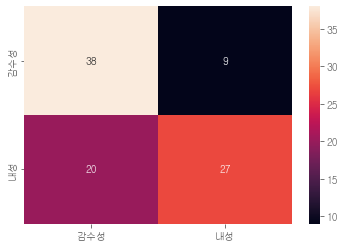

In [18]:


cm = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=predicted), columns=['감수성','내성'], index=['감수성','내성'])
sns.heatmap(cm, annot=True)

In [19]:
print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.66      0.81      0.72        47
           1       0.75      0.57      0.65        47

    accuracy                           0.69        94
   macro avg       0.70      0.69      0.69        94
weighted avg       0.70      0.69      0.69        94



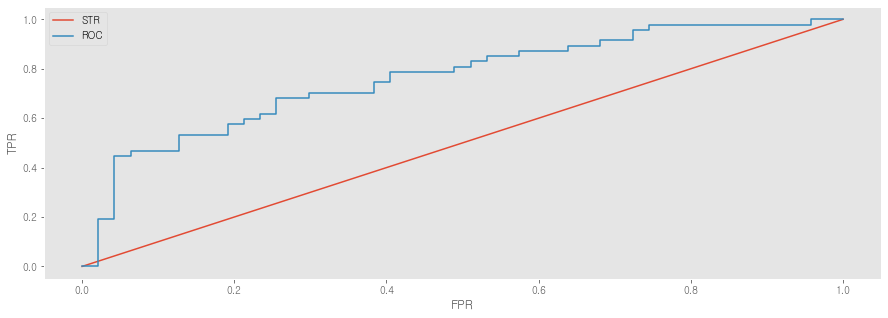

In [20]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best.predict_proba(x_test)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [21]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))




roc auc value 0.7618832050701675


결과, recall (내성)에 예측이 많이 실패한다.

# 변수 중요도



-  Weight : 변수 별 데이터를 분리하는데 쓰인 횟수 
-  Cover : 해당 변수로 분리된 데이터의 수
-  Gain : Feature을 사용했을 때 줄어드는 평균적인 training loss

3가지 방법을 통해 중요도를 나타낼 수 있다.

단점

1. 3가지 방법이 서로 다른 순위의 수치로 나타낸다면, 중요도를 파악하기 어렵다.
2. Positive or Negative 영향을 파악할 수 없다. (domain knowledge를 요구한다.)
3. Ensemble 모델에서 consistency가 보장되지 못한다. (특정 변수가 중요하다 판단하여 모델을 수정했는데, 오히려 중요도가 떨어질 수 있다.)


https://woolulu.tistory.com/28

# shap value

- shap value는 실제값과 예측값 사이의 차이를 이용해 중요도를 파악하는 방법
- 해당 변수의 값을 포함, 미포함 (수정) 의 차이를 구한다.

In [22]:

explainer = shap.TreeExplainer(model_best) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_train) # Shap Values 계산
shap_values_bar=explainer(x_train)

In [23]:
shap.initjs() # javascript 초기화 (graph 초기화)
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_train)

In [24]:
# 전체 검증 데이터 셋에 대해서 적용
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_train) 

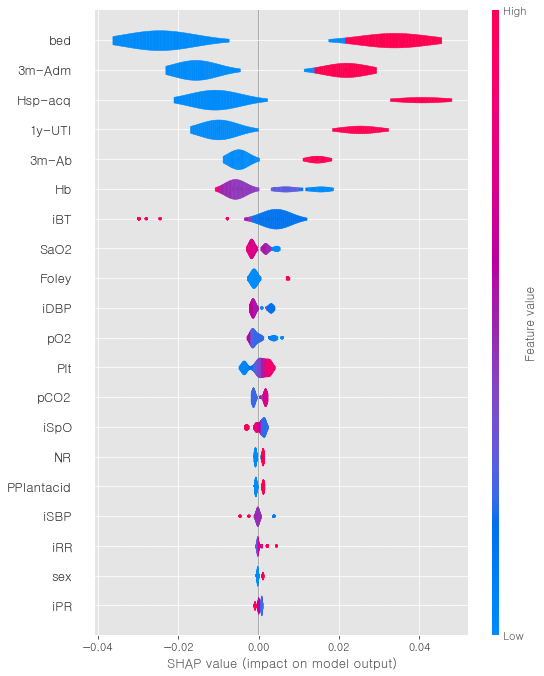

In [25]:
shap.summary_plot(shap_values[1], x_train, plot_type='violin')

내성을 양의 방향으로 Shap summary plot을 나타냈다.

결과, 총 20개의 유의한 변수를 추출했다. (기본적으로 20개만 추출된다.)

순서를 나타내면.

- category : bed, 3m-Adm, Hsp-acq, 1y-UTI,3m-Ab, Foley,PPlantacid,sex
- numeric : Hb, iBT, SaO2,iDBP,pO2,Plt pCO2,iSpO,NR,iSBP,iRR, iPR


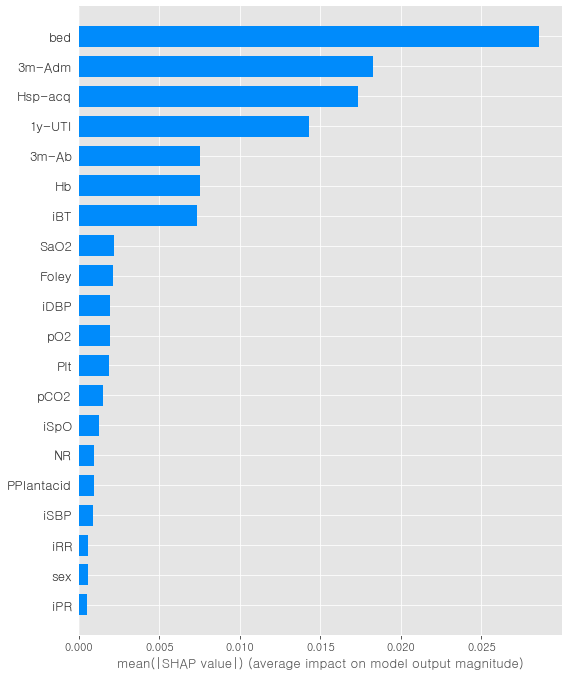

In [26]:
shap.summary_plot(shap_values[1], x_train, plot_type='bar',max_display=20)

In [27]:
print("column별 mean shap value")
mean_shap_values = []

for i,col in enumerate(list(x_train.columns)): 
    mean_shap = np.mean(np.abs(shap_values[1][:,i]))
    mean_shap_values.append(mean_shap)
    print("{}, {:.8f}".format(col,mean_shap))


column별 mean shap value
sex, 0.00053514
Age, 0.00000000
mc, 0.00000000
iSBP, 0.00086916
iDBP, 0.00194932
iPR, 0.00052403
iRR, 0.00055270
iBT, 0.00730500
iSpO, 0.00125980
Qsofa, 0.00000000
bed, 0.02855495
Foley, 0.00211884
Hsp-acq, 0.01734792
Nursing, 0.00000000
3m-Ab, 0.00751841
3m-Adm, 0.01824943
1y-UTI, 0.01427615
PPIantacid, 0.00092388
DM, 0.00000000
HTN, 0.00000000
CV, 0.00035144
CRF, 0.00000000
total malig, 0.00000000
NR, 0.00095250
pH, 0.00042877
pCO2, 0.00148028
pO2, 0.00192274
HCO3, 0.00036416
SaO2, 0.00218302
lactic acid, 0.00000000
Leukopenia, 0.00000000
WBC, 0.00043762
Hb, 0.00750876
Plt, 0.00186916
CRP, 0.00031852
Glu, 0.00000000
BUN, 0.00000000
Cr, 0.00026947


In [28]:
origin_shap_df=pd.DataFrame({ "col":list(x_train.columns),"mean_shap_values":mean_shap_values})
origin_shap_df=origin_shap_df.sort_values("mean_shap_values",ascending=False)
origin_shap_df.to_excel("origin_shap_val.xlsx",index=False)

In [29]:
sorted_list=list(origin_shap_df.sort_values(by='mean_shap_values',ascending=False)['col'])

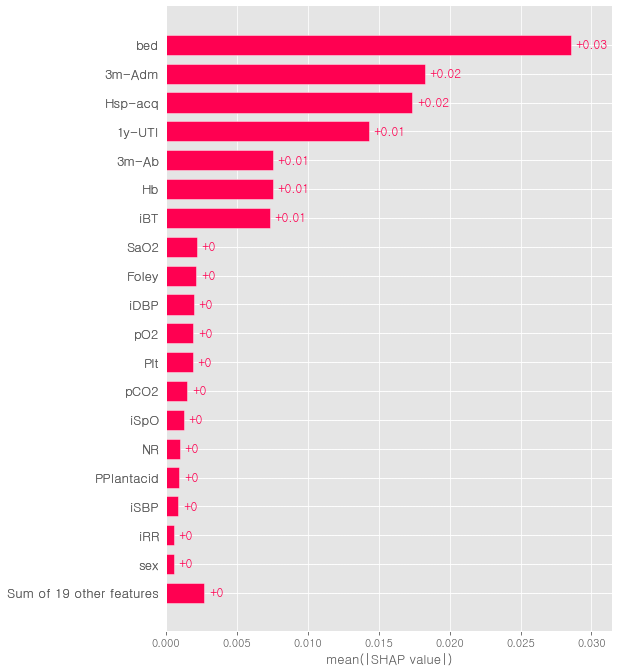

In [30]:
#전역 막대 플롯

shap.plots.bar(shap_values_bar[:,:,1],max_display=20)

# 변수 선택 및 분류

- logistic regression
- svm (종류?)
- random forest


5,10,15,20 증가시켜서 실험해본다.

In [14]:
origin_shap_df = pd.read_excel("./origin_shap_val.xlsx")
origin_shap_df

,col,mean_shap_values
0,bed,0.028555
1,3m-Adm,0.018249
2,Hsp-acq,0.017348
3,1y-UTI,0.014276
4,3m-Ab,0.007518
5,Hb,0.007509
6,iBT,0.007305
7,SaO2,0.002183
8,Foley,0.002119
9,iDBP,0.001949


In [15]:
col_all = origin_shap_df['col'].tolist()

In [16]:
#기초 전처리 데이터 출력
x_train_rftree = x_train.copy()
x_test_rftree = x_test.copy()

In [17]:
col_all[:20]

['bed',
 '3m-Adm',
 'Hsp-acq',
 '1y-UTI',
 '3m-Ab',
 'Hb',
 'iBT',
 'SaO2',
 'Foley',
 'iDBP',
 'pO2',
 'Plt',
 'pCO2',
 'iSpO',
 'NR',
 'PPIantacid',
 'iSBP',
 'iRR',
 'sex',
 'iPR']

## logistic regression

- https://bkshin.tistory.com/entry/DATA-22-%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1-%ED%9A%8C%EA%B7%80Logistic-Regression

- https://3months.tistory.com/28

In [35]:
test_logistic = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_logistic

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [36]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [37]:
import statsmodels.api as sm

numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

In [38]:
#표준화


scaler = StandardScaler()

x_train_base_logistic = x_train.copy()
x_test_base_logistic = x_test.copy()


x_train_base_logistic[numeric_cols] = scaler.fit_transform(x_train_base_logistic[numeric_cols])
x_test_base_logistic[numeric_cols] = scaler.transform(x_test_base_logistic[numeric_cols])




In [39]:
x_train_rftree_logistic20=x_train_base_logistic[col_all[:20]]
x_test_rftree_logistic20=x_test_base_logistic[col_all[:20]]

x_train_rftree_logistic10=x_train_base_logistic[col_all[:10]]
x_test_rftree_logistic10=x_test_base_logistic[col_all[:10]]

x_train_rftree_logistic15=x_train_base_logistic[col_all[:15]]
x_test_rftree_logistic15=x_test_base_logistic[col_all[:15]]

x_train_rftree_logistic17=x_train_base_logistic[col_all[:17]]
x_test_rftree_logistic17=x_test_base_logistic[col_all[:17]]

x_train_rftree_logistic25=x_train_base_logistic[col_all[:25]]
x_test_rftree_logistic25=x_test_base_logistic[col_all[:25]]

x_train_rftree_logistic30=x_train_base_logistic[col_all[:30]]
x_test_rftree_logistic30=x_test_base_logistic[col_all[:30]]




### baseline

In [40]:
x_train_base_logistic

,sex,Age,mc,iSBP,iDBP,iPR,iRR,iBT,iSpO,Qsofa,...,SaO2,lactic acid,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr
0,1,-0.058608,1,-1.085320,-0.436054,-1.071046,-0.647628,-0.190722,0.944275,2,...,-0.063714,-0.144962,0,0.655870,-0.130783,-0.416052,-0.069916,-0.710952,-0.206676,-0.278879
1,1,0.630679,0,-0.287102,-0.770929,-0.459287,-0.119356,-0.119012,0.532907,0,...,-0.001792,-0.733284,0,-0.974371,-0.381665,0.726910,0.084745,-0.669646,-0.349045,-0.543982
2,0,-0.610037,0,2.011765,1.238321,1.288597,1.993733,0.046475,0.121540,1,...,-0.015061,0.014044,0,-0.657833,0.036472,0.434085,0.091326,0.135818,-0.265184,-0.435222
3,1,-0.334322,0,-0.414817,0.233696,-0.852560,-0.119356,-0.102463,0.327224,0,...,0.013689,1.445098,1,-1.733763,-0.121491,-1.115054,1.885832,-0.628341,-0.115014,0.142566
4,0,-1.161466,0,1.181619,0.345321,0.414655,-0.119356,0.018894,-0.701194,0,...,-0.085829,-0.579578,0,-0.157021,-0.028571,0.849708,0.308509,0.817365,-0.196925,-0.421627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0,0.079250,0,0.830403,-0.212804,0.982717,-0.647628,0.013378,0.738591,0,...,0.002631,-0.547777,0,-0.351699,0.101516,0.282950,-0.739017,-0.173976,-0.331493,-0.496399
370,1,0.079250,1,-1.244964,-0.603491,0.764232,3.050277,-0.008687,0.121540,3,...,-0.110155,-0.266866,0,1.126961,0.017888,1.218101,0.420392,0.579856,0.680695,0.366883
371,1,0.492821,1,-0.638318,-0.603491,0.589443,0.937189,-0.113495,-3.169397,2,...,-0.256115,-0.558377,0,0.131281,-0.186535,1.680953,-0.613972,-1.423478,-0.079909,0.665973
372,0,0.630679,0,-0.223245,-0.603491,0.152472,-0.647628,-0.052817,0.327224,0,...,0.064553,-0.706783,0,-0.107980,-0.353790,3.069511,-0.635909,-0.700626,-0.374399,-0.346854


In [41]:


logit_mod = sm.Logit(y_train['CIP'], x_train_base_logistic)
results = logit_mod.fit()

#model_logistic = LogisticRegression( )
#model_logistic.fit( x_train_base_logistic, y_train['CIP'] )
#model_logistic.predict( x_test_base_logistic )

predicted = results.predict(x_test_base_logistic)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred = predicted, y_true = y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred = predicted, y_true = y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.544607
         Iterations 9
Baseline accuracy :  0.6595744680851063
Baseline recall :  0.574468085106383


In [42]:
results.pvalues[results.pvalues<0.05]

iRR        0.031350
bed        0.037054
Hsp-acq    0.003533
1y-UTI     0.004924
HTN        0.002025
SaO2       0.037970
BUN        0.022823
Cr         0.014980
dtype: float64

In [43]:
np.exp(results.params)

sex            0.722673
Age            1.089180
mc             1.200197
iSBP           0.793277
iDBP           1.004765
iPR            0.869539
iRR            1.472267
iBT            0.879638
iSpO           1.188916
Qsofa          0.607207
bed            2.368696
Foley          0.799324
Hsp-acq        4.127629
Nursing        1.377087
3m-Ab          1.842149
3m-Adm         0.955088
1y-UTI         2.517641
PPIantacid     0.983430
DM             1.005946
HTN            0.433745
CV             1.126003
CRF            1.318271
total malig    0.583345
NR             0.668323
pH             1.047344
pCO2           1.045451
pO2            1.091134
HCO3           1.301976
SaO2           0.014853
lactic acid    1.069856
Leukopenia     1.292365
WBC            1.048051
Hb             0.336965
Plt            1.018541
CRP            0.987730
Glu            1.045611
BUN            0.257500
Cr             2.381708
dtype: float64

In [44]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[35, 12],
       [20, 27]], dtype=int64)

In [45]:
print(classification_report(y_pred=predicted,y_true=y_test['CIP']) )

              precision    recall  f1-score   support

           0       0.64      0.74      0.69        47
           1       0.69      0.57      0.63        47

    accuracy                           0.66        94
   macro avg       0.66      0.66      0.66        94
weighted avg       0.66      0.66      0.66        94



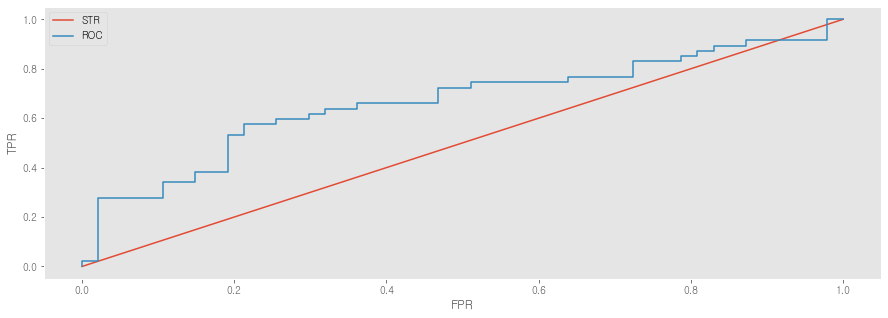

In [46]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_base_logistic)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [47]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))




roc auc value 0.6636487098234495


In [48]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### reduced (20개)

In [49]:
x_train_rftree_logistic20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bed         374 non-null    category
 1   3m-Adm      374 non-null    category
 2   Hsp-acq     374 non-null    category
 3   1y-UTI      374 non-null    category
 4   3m-Ab       374 non-null    category
 5   Hb          374 non-null    float64 
 6   iBT         374 non-null    float64 
 7   SaO2        374 non-null    float64 
 8   Foley       374 non-null    category
 9   iDBP        374 non-null    float64 
 10  pO2         374 non-null    float64 
 11  Plt         374 non-null    float64 
 12  pCO2        374 non-null    float64 
 13  iSpO        374 non-null    float64 
 14  NR          374 non-null    category
 15  PPIantacid  374 non-null    category
 16  iSBP        374 non-null    float64 
 17  iRR         374 non-null    float64 
 18  sex         374 non-null    category
 19  iPR     

In [50]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic20)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic20)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.594671
         Iterations 9
Baseline accuracy :  0.648936170212766
Baseline recall :  0.7659574468085106


In [51]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[25, 22],
       [11, 36]], dtype=int64)

In [52]:
print(classification_report(y_pred=predicted,y_true=y_test['CIP']) )

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        47
           1       0.62      0.77      0.69        47

    accuracy                           0.65        94
   macro avg       0.66      0.65      0.64        94
weighted avg       0.66      0.65      0.64        94



In [53]:
results.pvalues[results.pvalues<0.05]

Hsp-acq    0.002520
1y-UTI     0.012920
NR         0.019598
dtype: float64

In [54]:
np.exp(results.params)

bed           1.892702
3m-Adm        0.836654
Hsp-acq       3.453225
1y-UTI        2.147419
3m-Ab         1.649367
Hb            0.388725
iBT           0.880874
SaO2          0.231265
Foley         0.979124
iDBP          1.020863
pO2           0.947046
Plt           1.125671
pCO2          1.133671
iSpO          1.091417
NR            0.512287
PPIantacid    0.683705
iSBP          0.853013
iRR           1.205318
sex           0.802530
iPR           0.885492
dtype: float64

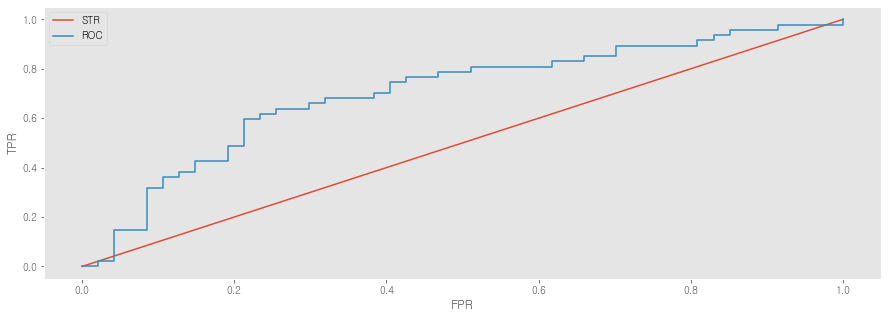

In [55]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic20)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [56]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7016749660479854


In [57]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [58]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic10)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic10)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.618277
         Iterations 8
Baseline accuracy :  0.5212765957446809
Baseline recall :  0.7872340425531915


In [59]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[12, 35],
       [10, 37]], dtype=int64)

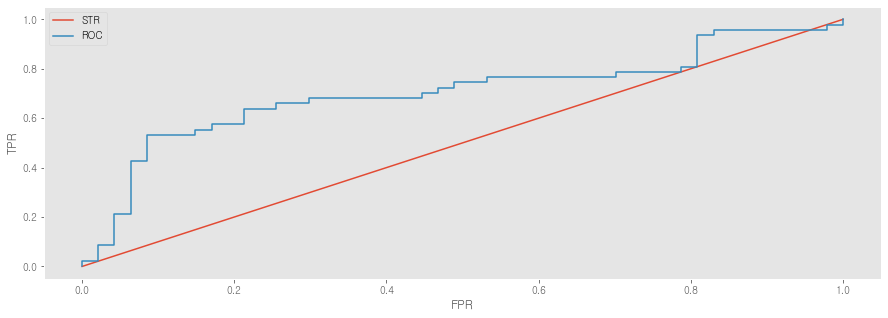

In [60]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic10)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [61]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7025803531009507


In [62]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [63]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic15)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic15)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.604080
         Iterations 9
Baseline accuracy :  0.6382978723404256
Baseline recall :  0.8085106382978723


In [64]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[22, 25],
       [ 9, 38]], dtype=int64)

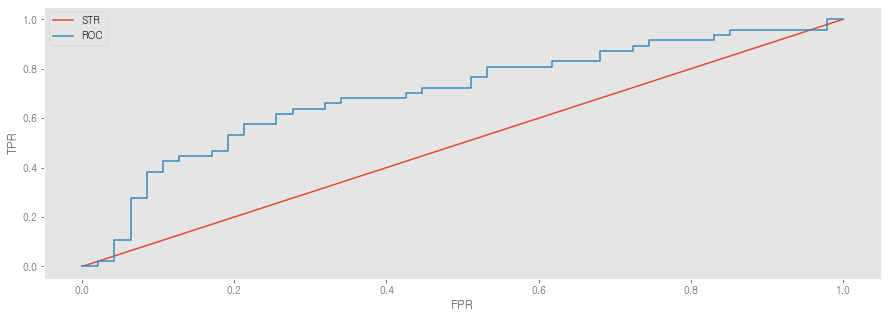

In [65]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic15)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [66]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.6994114984155726


In [67]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [68]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic17)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic17)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.598576
         Iterations 9
Baseline accuracy :  0.5957446808510638
Baseline recall :  0.7659574468085106


In [69]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[20, 27],
       [11, 36]], dtype=int64)

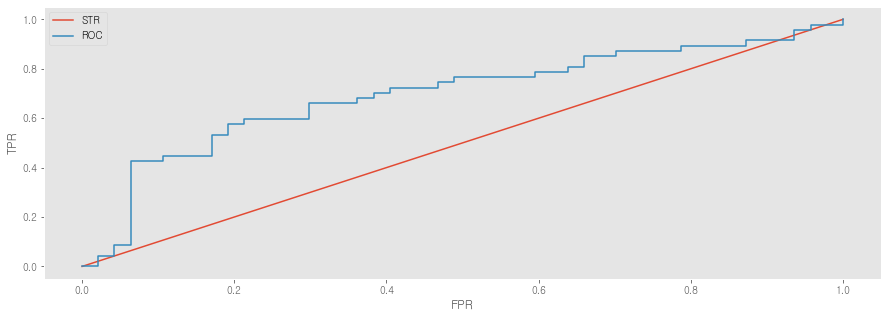

In [70]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic17)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [71]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.6962426437301947


In [72]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [73]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic25)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic25)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.590603
         Iterations 9
Baseline accuracy :  0.648936170212766
Baseline recall :  0.7446808510638298


In [74]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[26, 21],
       [12, 35]], dtype=int64)

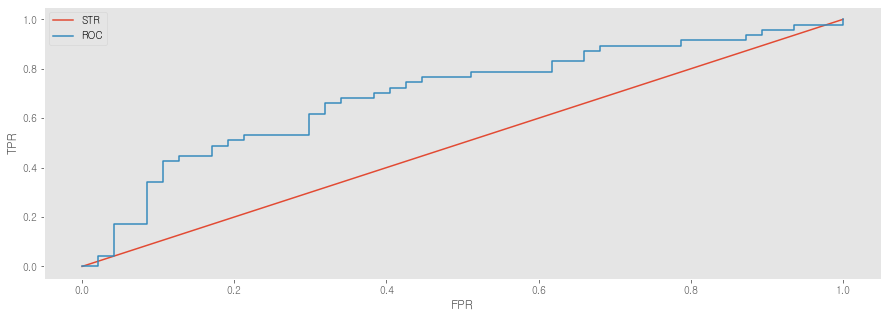

In [75]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic25)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [76]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.694884563150747


In [77]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [78]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic30)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic30)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.579174
         Iterations 9
Baseline accuracy :  0.6276595744680851
Baseline recall :  0.723404255319149


In [79]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[25, 22],
       [13, 34]], dtype=int64)

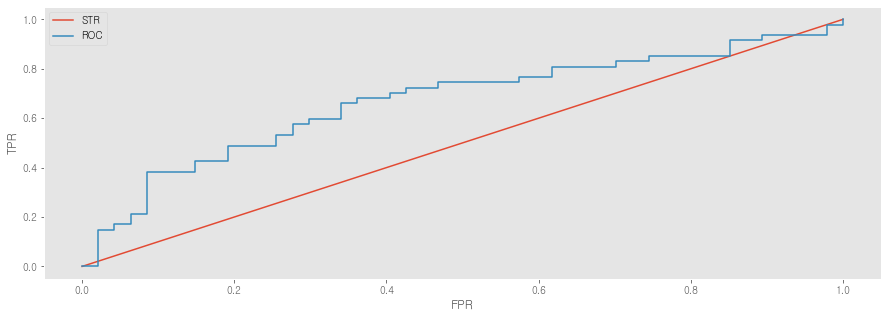

In [80]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic30)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [81]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.6686283386147578


In [82]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [83]:
test_logistic= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_logistic.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [84]:
test_logistic.sort_values('name')

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,logistic_10,0.702580,0.521277,0.787234,0.255319,0.621849
3,logistic_15,0.699411,0.638298,0.808511,0.468085,0.690909
4,logistic_17,0.696243,0.595745,0.765957,0.425532,0.654545
1,logistic_20,0.701675,0.648936,0.765957,0.531915,0.685714
5,logistic_25,0.694885,0.648936,0.744681,0.553191,0.679612
6,logistic_30,0.668628,0.627660,0.723404,0.531915,0.660194
0,logistic_base,0.663649,0.659574,0.574468,0.744681,0.627907


## svm

- https://blog.naver.com/winddori2002/221667083964

### baseline

In [1]:
test_svm = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_svm

NameError: name 'pd' is not defined

In [ ]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [87]:
import statsmodels.api as sm

numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

In [88]:
#표준화


scaler = StandardScaler()

x_train_rf_svm = x_train.copy()
x_test_rf_svm = x_test.copy()


x_train_rf_svm[numeric_cols] = scaler.fit_transform(x_train_rf_svm[numeric_cols])
x_test_rf_svm[numeric_cols] = scaler.transform(x_test_rf_svm[numeric_cols])




In [89]:
#변수들 선언

x_train_rftree_svm = x_train_rf_svm.copy() # 38개 변수
x_test_rftree_svm = x_test_rf_svm.copy()

x_train_rftree_svm20=x_train_rftree_svm[col_all[:20]] #norm 변환 완료된 20개 변수
x_test_rftree_svm20=x_test_rftree_svm[col_all[:20]]

x_train_rftree_svm10=x_train_rftree_svm[col_all[:10]]
x_test_rftree_svm10=x_test_rftree_svm[col_all[:10]]

x_train_rftree_svm15=x_train_rftree_svm[col_all[:15]]
x_test_rftree_svm15=x_test_rftree_svm[col_all[:15]]

x_train_rftree_svm17=x_train_rftree_svm[col_all[:17]]
x_test_rftree_svm17=x_test_rftree_svm[col_all[:17]]


x_train_rftree_svm25=x_train_rftree_svm[col_all[:25]]
x_test_rftree_svm25=x_test_rftree_svm[col_all[:25]]

x_train_rftree_svm30=x_train_rftree_svm[col_all[:30]]
x_test_rftree_svm30=x_test_rftree_svm[col_all[:30]]




In [90]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.694955
1,0.010,0.668324
3,1.000,0.668216
4,10.000,0.652180
6,50.000,0.646847
7,100.000,0.646847
5,25.000,0.646811
0,0.001,0.502667


In [91]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [92]:
from sklearn.metrics import accuracy_score


predicted = model_best_svm.predict(x_test_rftree_svm)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.691
recall score: 0.574


In [93]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rf_svm, y_train['CIP'])


SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

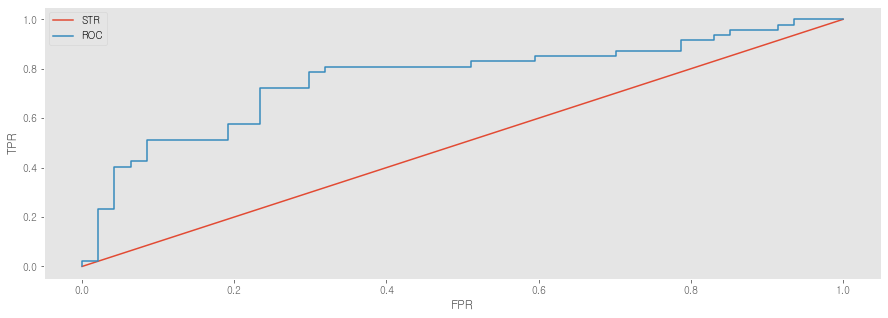

In [94]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rf_svm)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [95]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7596197374377547


In [96]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### reduced (20개)

In [97]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm20, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.713514
3,1.000,0.705694
4,10.000,0.705658
7,100.000,0.705658
5,25.000,0.702991
6,50.000,0.702991
1,0.010,0.686991
0,0.001,0.502667


In [98]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [99]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm20)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.553


In [100]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm20, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

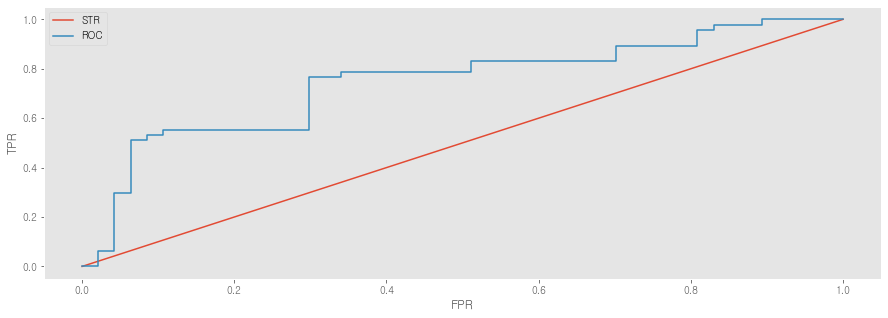

In [101]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [102]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7455862381167949


In [103]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [104]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm10, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
4,10.000,0.719027
6,50.000,0.719027
5,25.000,0.718991
3,1.000,0.716360
7,100.000,0.716324
2,0.100,0.716252
1,0.010,0.686955
0,0.001,0.502667


In [105]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 10}


In [106]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm10)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.745
recall score: 0.617


In [107]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=10,probability=True)
model_best_svm.fit(x_train_rftree_svm10, y_train['CIP'])



SVC(C=10, kernel='linear', probability=True, random_state=1234)

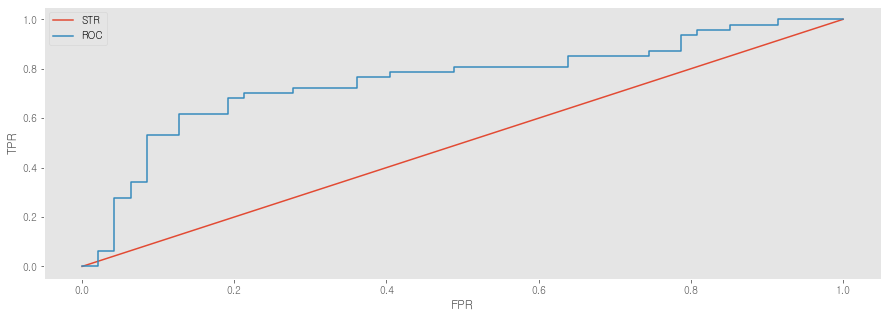

In [108]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [109]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7532820280669986


In [110]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [111]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm15, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.716252
6,50.000,0.710991
3,1.000,0.708324
5,25.000,0.705586
7,100.000,0.705586
4,10.000,0.702919
1,0.010,0.689586
0,0.001,0.502667


In [112]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [113]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm15)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.553


In [114]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm15, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

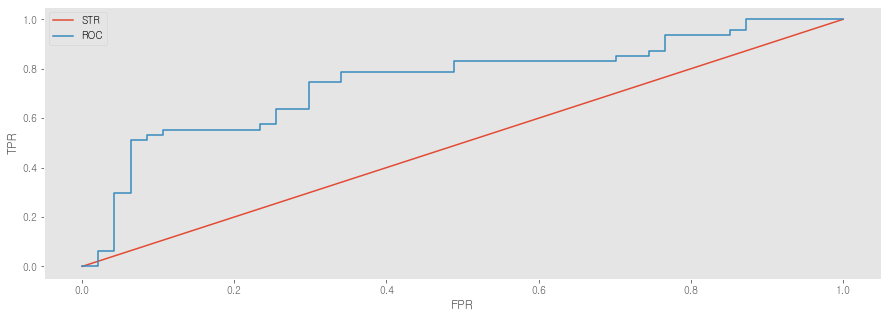

In [115]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [116]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7478497057492078


In [117]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [118]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm17, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.716252
7,100.000,0.713730
4,10.000,0.713694
5,25.000,0.713694
6,50.000,0.708324
3,1.000,0.702919
1,0.010,0.697694
0,0.001,0.502667


In [119]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [120]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm17)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.553


In [121]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm17, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

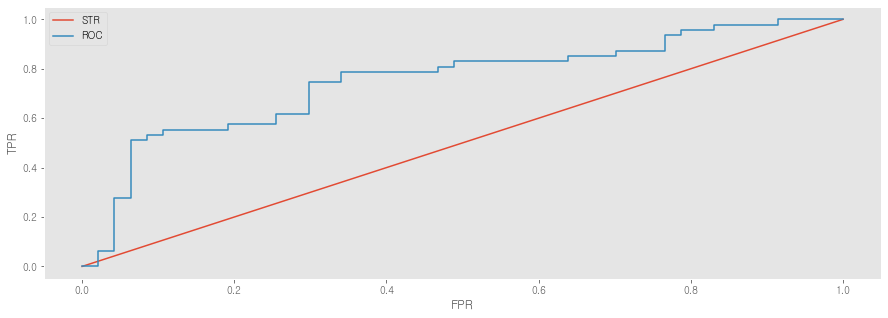

In [122]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [123]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7514712539610683


In [124]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [125]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm25, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.697514
4,10.000,0.694919
3,1.000,0.689622
1,0.010,0.684324
7,100.000,0.684252
5,25.000,0.681586
6,50.000,0.681586
0,0.001,0.502667


In [126]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [127]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm25)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.723
recall score: 0.553


In [128]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm25, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

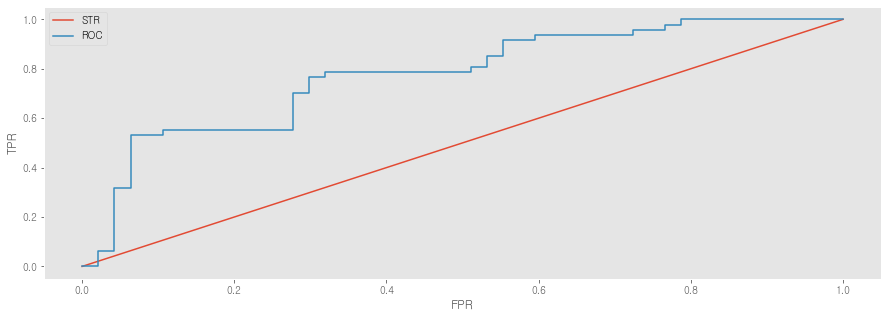

In [129]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [130]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7750113173381621


In [131]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [132]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm30, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
3,1.000,0.694883
2,0.100,0.692144
4,10.000,0.678847
1,0.010,0.671027
6,50.000,0.670847
7,100.000,0.668180
5,25.000,0.668144
0,0.001,0.502667


In [133]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 1}


In [134]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm30)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.617


In [135]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm30, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

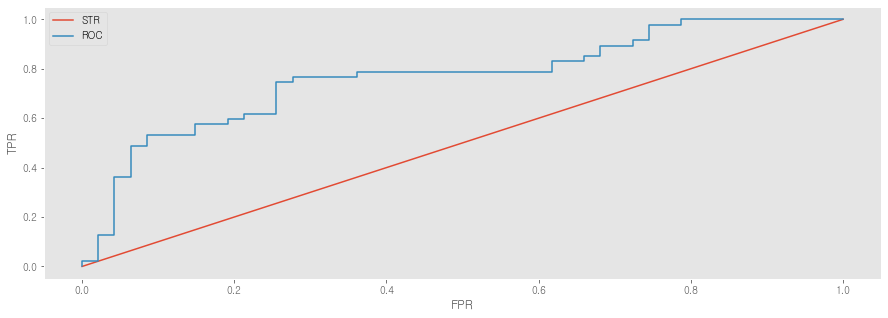

In [136]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [137]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7659574468085106


In [138]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [139]:
test_svm= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_svm.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [140]:
test_svm.sort_values('name')

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,svm_10,0.753282,0.744681,0.617021,0.872340,0.707317
3,svm_15,0.747850,0.712766,0.553191,0.872340,0.658228
4,svm_17,0.751471,0.712766,0.553191,0.872340,0.658228
1,svm_20,0.745586,0.712766,0.553191,0.872340,0.658228
5,svm_25,0.775011,0.723404,0.553191,0.893617,0.666667
6,svm_30,0.765957,0.712766,0.617021,0.808511,0.682353
0,svm_base,0.759620,0.691489,0.574468,0.808511,0.650602


## random forest

In [56]:
test_rf = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_rf

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [57]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [143]:
#변수들 선언

x_train_rftree_rf = x_train.copy() # 38개 변수
x_test_rftree_rf = x_test.copy()

x_train_rftree_rf20=x_train_rftree_rf[col_all[:20]] #norm 변환 완료된 20개 변수
x_test_rftree_rf20=x_test_rftree_rf[col_all[:20]]

x_train_rftree_rf10=x_train_rftree_rf[col_all[:10]]
x_test_rftree_rf10=x_test_rftree_rf[col_all[:10]]

x_train_rftree_rf15=x_train_rftree_rf[col_all[:15]]
x_test_rftree_rf15=x_test_rftree_rf[col_all[:15]]

x_train_rftree_rf17=x_train_rftree_rf[col_all[:17]]
x_test_rftree_rf17=x_test_rftree_rf[col_all[:17]]


x_train_rftree_rf25=x_train_rftree_rf[col_all[:25]]
x_test_rftree_rf25=x_test_rftree_rf[col_all[:25]]

x_train_rftree_rf30=x_train_rftree_rf[col_all[:30]]
x_test_rftree_rf30=x_test_rftree_rf[col_all[:30]]

### reduced (20개)

In [144]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf20, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [145]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 240, 'max_depth': 1}


In [146]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf20)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.691
recall score: 0.574


<AxesSubplot:>

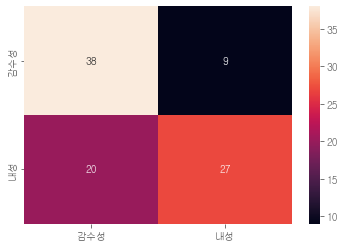

In [147]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=predicted), columns=['감수성','내성'], index=['감수성','내성'])
sns.heatmap(cm, annot=True)

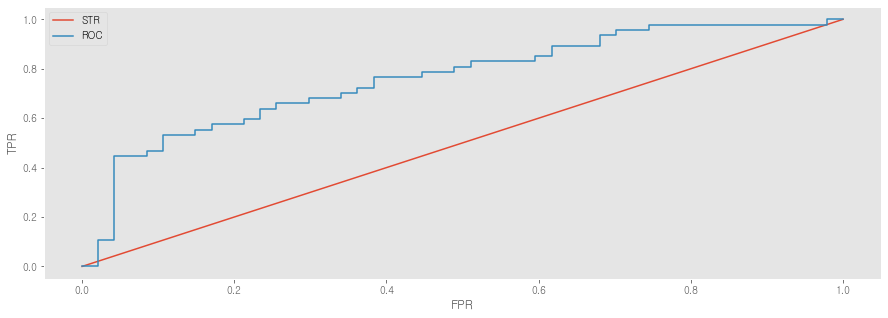

In [148]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = model_best2.predict_proba(x_test_rftree_rf20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [149]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test, pred_positive_label) ))



roc auc value 0.7600724309642373


In [150]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


변수를 축약하여, 오히려 accuracy, recall이 조금 상승했다.

### 변수 10

In [151]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf10, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [152]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 200, 'max_depth': 3}


In [153]:
model_best2= RandomForestClassifier(n_estimators=390,max_depth=1,random_state=1234)
model_best2.fit(x_train_rftree_rf10, y_train['CIP'])

RandomForestClassifier(max_depth=1, n_estimators=390, random_state=1234)

In [154]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf10)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.702
recall score: 0.553


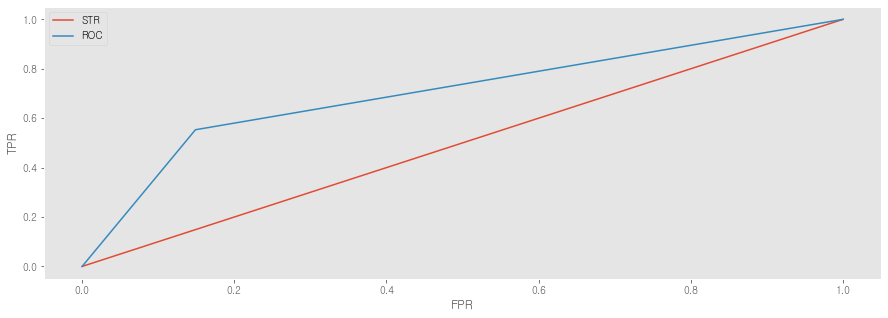

In [155]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict(x_test_rftree_rf10)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [156]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.7021276595744682


In [157]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [158]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf15, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [159]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 90, 'max_depth': 3}


In [160]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf15, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [161]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf15)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.702
recall score: 0.596


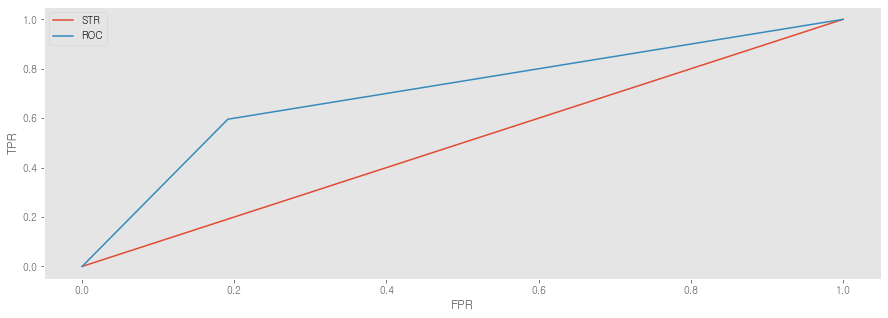

In [162]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict(x_test_rftree_rf15)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [163]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.7021276595744681


In [164]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [165]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf17, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [166]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 240, 'max_depth': 2}


In [167]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf17, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [168]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf17)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.67
recall score: 0.553


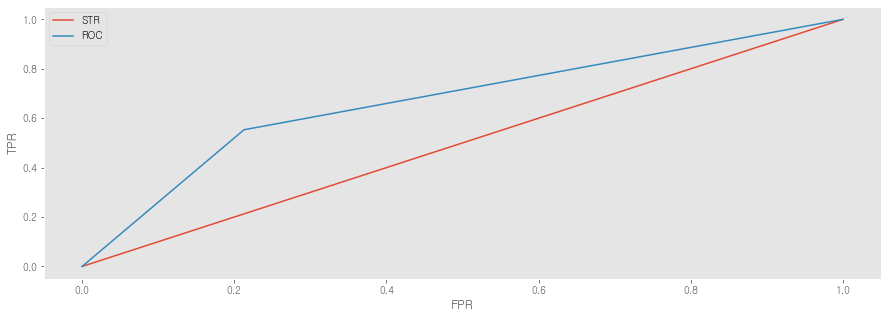

In [169]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict(x_test_rftree_rf17)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [170]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.6702127659574468


In [171]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [172]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf25, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [173]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 180, 'max_depth': 3}


In [174]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf25, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [175]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf25)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.67
recall score: 0.553


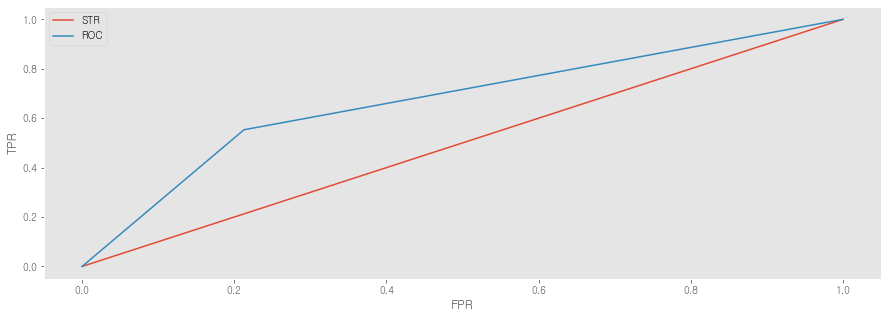

In [176]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict(x_test_rftree_rf25)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [177]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.6702127659574468


In [178]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [179]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf30, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [180]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 240, 'max_depth': 1}


In [181]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf30, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [182]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf30)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.691
recall score: 0.638


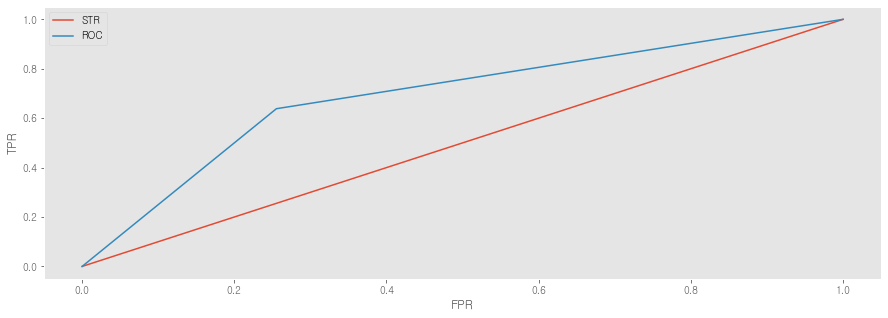

In [183]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict(x_test_rftree_rf30)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [184]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.6914893617021277


In [185]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [186]:
test_rf= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_rf.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [187]:


test_rf=test_rf.append({'name':'rf_base','AUC':0.7618,'ACC':0.691,'RECALL':0.574,'SPECIFICITY':0.809,'F1':0.651},ignore_index=True)
test_rf

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,rf_20,0.760072,0.691489,0.574468,0.808511,0.650602
1,rf_10,0.702128,0.702128,0.553191,0.851064,0.650000
2,rf_15,0.702128,0.702128,0.595745,0.808511,0.666667
3,rf_17,0.670213,0.670213,0.553191,0.787234,0.626506
4,rf_25,0.670213,0.670213,0.553191,0.787234,0.626506
5,rf_30,0.691489,0.691489,0.638298,0.744681,0.674157
6,rf_base,0.761800,0.691000,0.574000,0.809000,0.651000


In [ ]:
STOP....

## Gradient Boost

In [55]:
test_gbm = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_gbm

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [56]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [57]:

x_train_base_gbm = x_train.copy()
x_test_base_gbm = x_test.copy()



In [58]:
x_train_rftree_gbm20=x_train_base_gbm[col_all[:20]]
x_test_rftree_gbm20=x_test_base_gbm[col_all[:20]]

x_train_rftree_gbm10=x_train_base_gbm[col_all[:10]]
x_test_rftree_gbm10=x_test_base_gbm[col_all[:10]]

x_train_rftree_gbm15=x_train_base_gbm[col_all[:15]]
x_test_rftree_gbm15=x_test_base_gbm[col_all[:15]]

x_train_rftree_gbm17=x_train_base_gbm[col_all[:17]]
x_test_rftree_gbm17=x_test_base_gbm[col_all[:17]]

x_train_rftree_gbm25=x_train_base_gbm[col_all[:25]]
x_test_rftree_gbm25=x_test_base_gbm[col_all[:25]]

x_train_rftree_gbm30=x_train_base_gbm[col_all[:30]]
x_test_rftree_gbm30=x_test_base_gbm[col_all[:30]]




### baseline

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_base_gbm, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_base_gbm)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(10, 500, 10)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=2)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6809
학습 시간 : 0.1423
Fitting 5 folds for each of 441 candidates, totalling 2205 fits
최적의 파라미터: {'learning_rate': 0.06999999999999999, 'n_estimators': 10}
최고의 정확도 : 0.7058738738738738


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [59]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.07, n_estimators= 10,random_state=123)
gb_clf.fit(x_train_base_gbm, y_train['CIP'])
predicted = gb_clf.predict(x_test_base_gbm)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7021


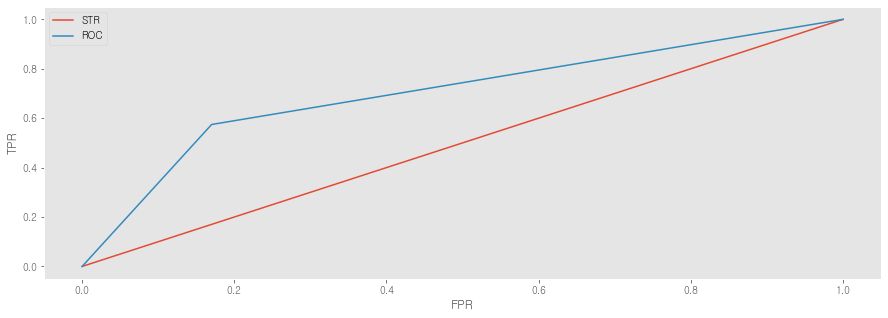

In [60]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict(x_test_base_gbm)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [61]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7021276595744681


In [62]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### reduced (20)

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm20, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm20)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6596
학습 시간 : 0.0952
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.02, 'n_estimators': 26}
최고의 정확도 : 0.7005405405405405


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [66]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.02, n_estimators= 26,random_state=123)
gb_clf.fit(x_train_rftree_gbm20, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm20)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7021


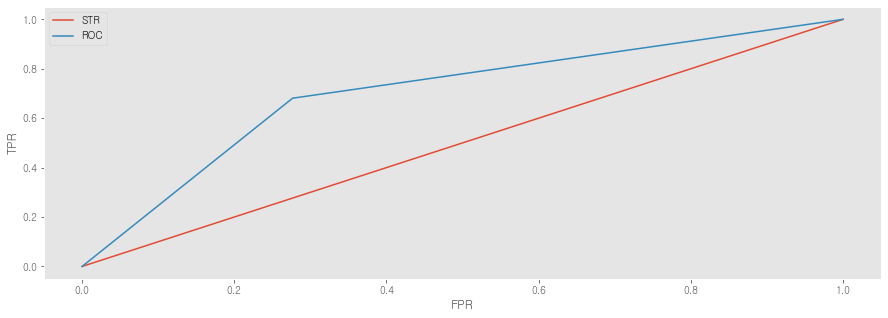

In [67]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict(x_test_rftree_gbm20)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [68]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm10, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm10)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6277
학습 시간 : 0.0612
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.05, 'n_estimators': 16}
최고의 정확도 : 0.7032072072072072


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [70]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.05, n_estimators= 16,random_state=123)
gb_clf.fit(x_train_rftree_gbm10, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm10)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7021


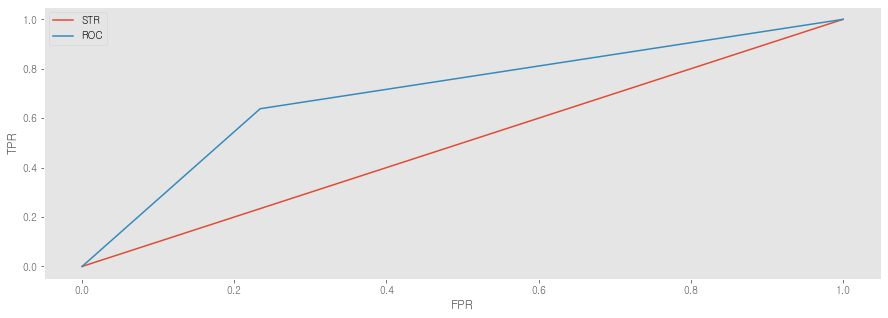

In [71]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict(x_test_rftree_gbm10)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [72]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm15, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm15)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6809
학습 시간 : 0.0800
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.02, 'n_estimators': 26}
최고의 정확도 : 0.7032072072072072


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [74]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.02, n_estimators= 26,random_state=123)
gb_clf.fit(x_train_rftree_gbm15, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm15)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.6809


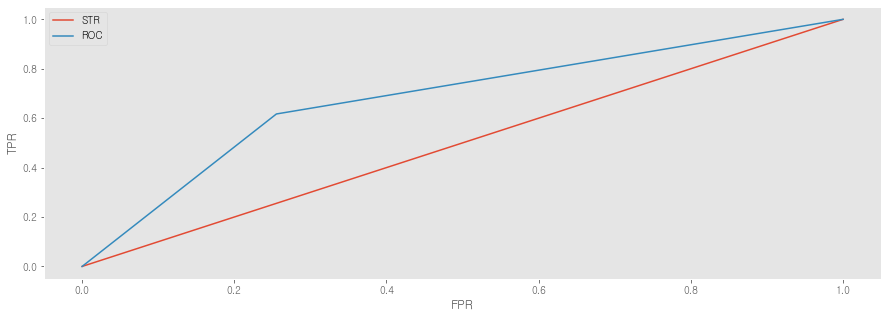

In [75]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict(x_test_rftree_gbm15)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [76]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm17, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm17)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6915
학습 시간 : 0.0889
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.06999999999999999, 'n_estimators': 11}
최고의 정확도 : 0.7032072072072072


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [78]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.07, n_estimators= 11,random_state=123)
gb_clf.fit(x_train_rftree_gbm17, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm17)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7128


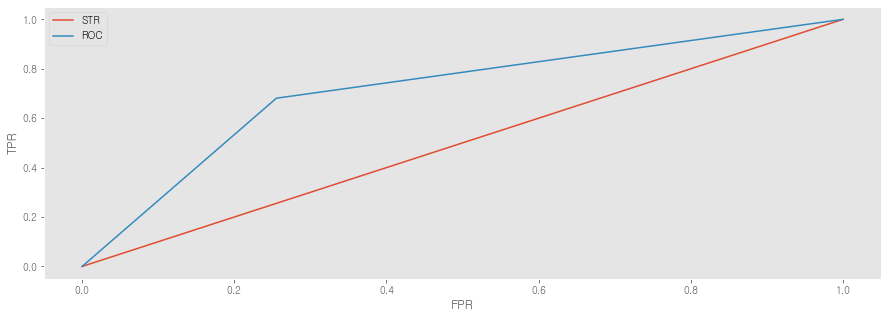

In [79]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict(x_test_rftree_gbm17)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [80]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm25, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm25)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6277
학습 시간 : 0.1210
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.06999999999999999, 'n_estimators': 11}
최고의 정확도 : 0.7032072072072072


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [82]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.07, n_estimators= 11,random_state=123)
gb_clf.fit(x_train_rftree_gbm25, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm25)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.6915


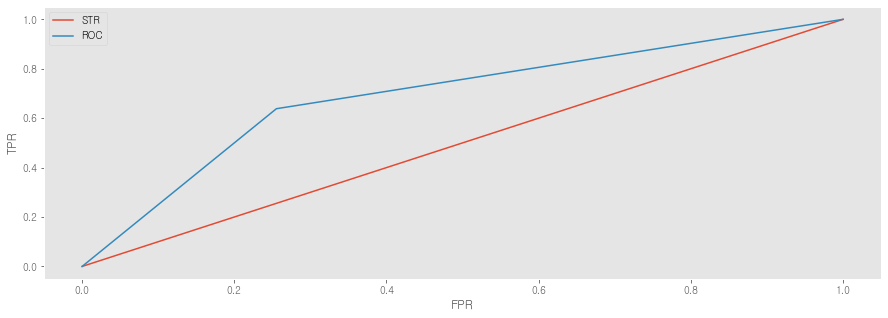

In [83]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict(x_test_rftree_gbm25)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [84]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [85]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm30, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm30)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6702
학습 시간 : 0.1330
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.02, 'n_estimators': 26}
최고의 정확도 : 0.7005405405405405


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [86]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.02, n_estimators= 26,random_state=123)
gb_clf.fit(x_train_rftree_gbm30, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm30)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.6915


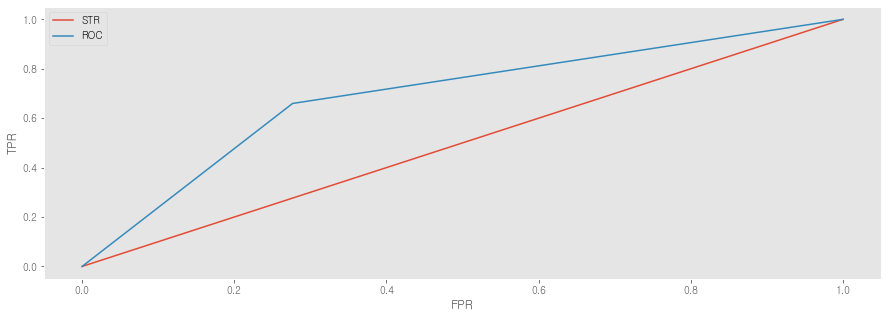

In [87]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict(x_test_rftree_gbm30)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [88]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [90]:
test_gbm= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_gbm.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [93]:
test_gbm.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,gbm_10,0.702128,0.702128,0.638298,0.765957,0.681818
3,gbm_15,0.680851,0.680851,0.617021,0.744681,0.659091
4,gbm_17,0.712766,0.712766,0.680851,0.744681,0.703297
1,gbm_20,0.702128,0.702128,0.680851,0.723404,0.695652
5,gbm_25,0.691489,0.691489,0.638298,0.744681,0.674157
6,gbm_30,0.691489,0.691489,0.659574,0.723404,0.681319
0,gbm_base,0.702128,0.702128,0.574468,0.829787,0.658537


In [ ]:
STOP....

## MLP

In [35]:
test_mlp = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [36]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [37]:
x_train_base_mlp = x_train.copy()
x_test_base_mlp = x_test.copy()

import statsmodels.api as sm

numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

scaler = StandardScaler()


x_train_base_mlp[numeric_cols] = scaler.fit_transform(x_train_base_mlp[numeric_cols])
x_test_base_mlp[numeric_cols] = scaler.transform(x_test_base_mlp[numeric_cols])


In [38]:
x_train_rftree_mlp20=x_train_base_mlp[col_all[:20]]
x_test_rftree_mlp20=x_test_base_mlp[col_all[:20]]

x_train_rftree_mlp10=x_train_base_mlp[col_all[:10]]
x_test_rftree_mlp10=x_test_base_mlp[col_all[:10]]

x_train_rftree_mlp15=x_train_base_mlp[col_all[:15]]
x_test_rftree_mlp15=x_test_base_mlp[col_all[:15]]

x_train_rftree_mlp17=x_train_base_mlp[col_all[:17]]
x_test_rftree_mlp17=x_test_base_mlp[col_all[:17]]

x_train_rftree_mlp25=x_train_base_mlp[col_all[:25]]
x_test_rftree_mlp25=x_test_base_mlp[col_all[:25]]

x_train_rftree_mlp30=x_train_base_mlp[col_all[:30]]
x_test_rftree_mlp30=x_test_base_mlp[col_all[:30]]




### baseline

In [39]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_base_mlp_exp, x_val_base_mlp_exp,\
y_train_base_mlp_exp, y_val_base_mlp_exp = train_test_split(x_train_base_mlp,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류
print("train :{} / valid : {} ".format(y_train_base_mlp_exp.shape[0],y_val_base_mlp_exp.shape[0] ))

train :299 / valid : 75 


In [41]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp))

    return clf.score(x_val_base_mlp_exp, np.ravel(y_val_base_mlp_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [42]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_base_mlp_exp, np.ravel(y_val_base_mlp_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_base_mlp, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_base_mlp)

best params :  {'n_layers': 1, 'n_units_0': 73}
훈련 세트 정확도: 0.903
검증 세트 정확도: 0.760
테스트 세트 정확도: 0.628


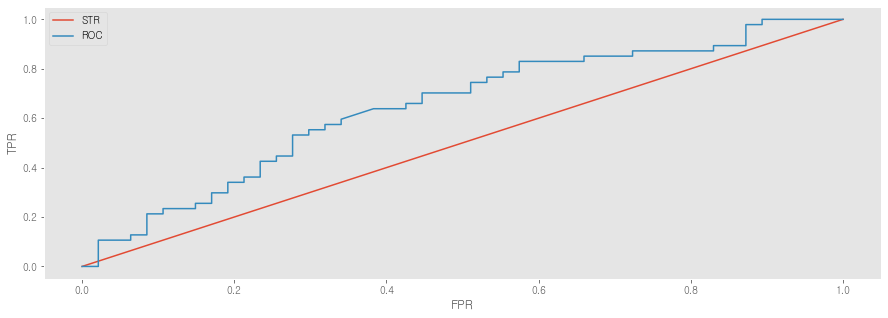

In [43]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_base_mlp)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [44]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [45]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [46]:
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,mlp_base,0.646446,0.62766,0.702128,0.553191,0.653465


### reduced (20)

In [47]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp20_exp, x_val_rftree_mlp20_exp,\
y_train_rftree_mlp20_exp, y_val_rftree_mlp20_exp = train_test_split(x_train_rftree_mlp20,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [48]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp20_exp, np.ravel(y_train_rftree_mlp20_exp))

    return clf.score(x_val_rftree_mlp20_exp, np.ravel(y_val_rftree_mlp20_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [49]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp20_exp, np.ravel(y_train_rftree_mlp20_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp20_exp, np.ravel(y_train_rftree_mlp20_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp20_exp, np.ravel(y_val_rftree_mlp20_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp20, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp20)

best params :  {'n_layers': 2, 'n_units_0': 40, 'n_units_1': 27}
훈련 세트 정확도: 0.883
검증 세트 정확도: 0.773
테스트 세트 정확도: 0.702


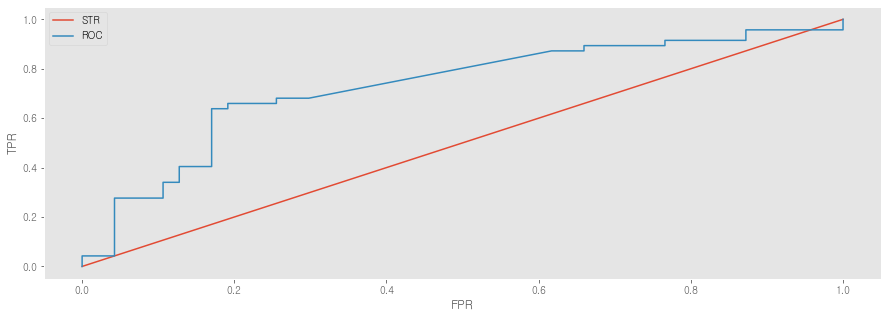

In [50]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [51]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [52]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [53]:
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889


### 변수 10

In [55]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp10_exp, x_val_rftree_mlp10_exp,\
y_train_rftree_mlp10_exp, y_val_rftree_mlp10_exp = train_test_split(x_train_rftree_mlp10,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [56]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp10_exp, np.ravel(y_train_rftree_mlp10_exp))

    return clf.score(x_val_rftree_mlp10_exp, np.ravel(y_val_rftree_mlp10_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [57]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp10_exp, np.ravel(y_train_rftree_mlp10_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp10_exp, np.ravel(y_train_rftree_mlp10_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp10_exp, np.ravel(y_val_rftree_mlp10_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp10, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp10)

best params :  {'n_layers': 4, 'n_units_0': 29, 'n_units_1': 26, 'n_units_2': 90, 'n_units_3': 27}
훈련 세트 정확도: 0.749
검증 세트 정확도: 0.813
테스트 세트 정확도: 0.681


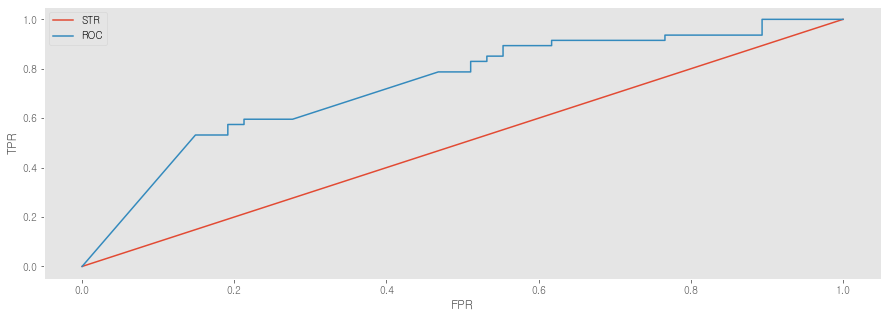

In [58]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [59]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [60]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [61]:
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889
2,mlp_10,0.733364,0.680851,0.595745,0.765957,0.651163


### 변수 15

In [62]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp15_exp, x_val_rftree_mlp15_exp,\
y_train_rftree_mlp15_exp, y_val_rftree_mlp15_exp = train_test_split(x_train_rftree_mlp15,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [64]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp15_exp, np.ravel(y_train_rftree_mlp15_exp))

    return clf.score(x_val_rftree_mlp15_exp, np.ravel(y_val_rftree_mlp15_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [65]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp15_exp, np.ravel(y_train_rftree_mlp15_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp15_exp, np.ravel(y_train_rftree_mlp15_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp15_exp, np.ravel(y_val_rftree_mlp15_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp15, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp15)

best params :  {'n_layers': 4, 'n_units_0': 37, 'n_units_1': 62, 'n_units_2': 50, 'n_units_3': 97}
훈련 세트 정확도: 0.756
검증 세트 정확도: 0.813
테스트 세트 정확도: 0.670


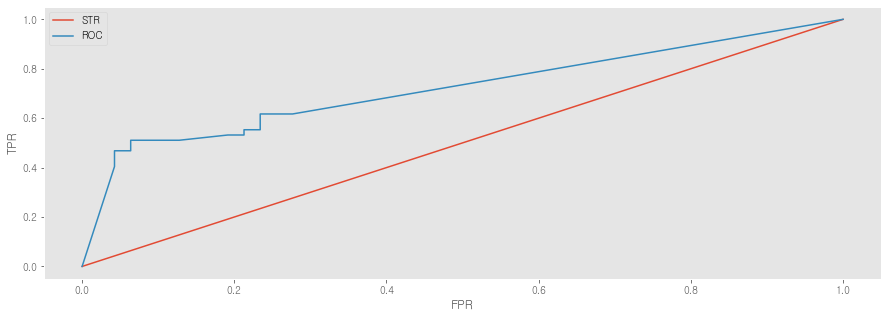

In [66]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [67]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [70]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp17_exp, x_val_rftree_mlp17_exp,\
y_train_rftree_mlp17_exp, y_val_rftree_mlp17_exp = train_test_split(x_train_rftree_mlp17,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [69]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp17_exp, np.ravel(y_train_rftree_mlp17_exp))

    return clf.score(x_val_rftree_mlp17_exp, np.ravel(y_val_rftree_mlp17_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [71]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp17_exp, np.ravel(y_train_rftree_mlp17_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp17_exp, np.ravel(y_train_rftree_mlp17_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp17_exp, np.ravel(y_val_rftree_mlp17_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp17, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp17)

best params :  {'n_layers': 3, 'n_units_0': 61, 'n_units_1': 33, 'n_units_2': 100}
훈련 세트 정확도: 0.779
검증 세트 정확도: 0.773
테스트 세트 정확도: 0.702


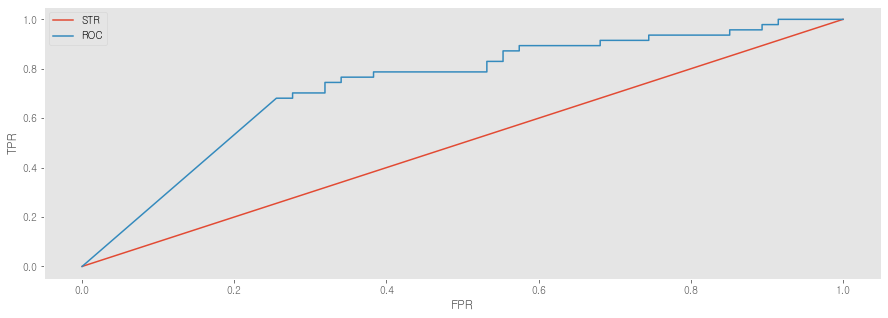

In [72]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [73]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [75]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp25_exp, x_val_rftree_mlp25_exp,\
y_train_rftree_mlp25_exp, y_val_rftree_mlp25_exp = train_test_split(x_train_rftree_mlp25,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [76]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp25_exp, np.ravel(y_train_rftree_mlp25_exp))

    return clf.score(x_val_rftree_mlp25_exp, np.ravel(y_val_rftree_mlp25_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [77]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp25_exp, np.ravel(y_train_rftree_mlp25_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp25_exp, np.ravel(y_train_rftree_mlp25_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp25_exp, np.ravel(y_val_rftree_mlp25_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp25, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp25)

best params :  {'n_layers': 3, 'n_units_0': 57, 'n_units_1': 33, 'n_units_2': 42}
훈련 세트 정확도: 0.753
검증 세트 정확도: 0.760
테스트 세트 정확도: 0.691


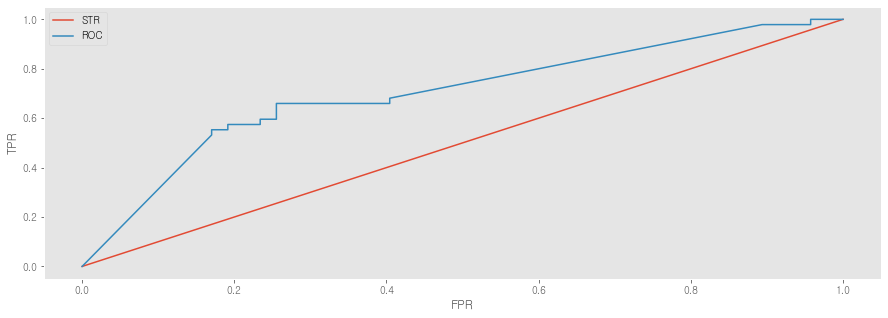

In [78]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [79]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [81]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp30_exp, x_val_rftree_mlp30_exp,\
y_train_rftree_mlp30_exp, y_val_rftree_mlp30_exp = train_test_split(x_train_rftree_mlp30,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [82]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp30_exp, np.ravel(y_train_rftree_mlp30_exp))

    return clf.score(x_val_rftree_mlp30_exp, np.ravel(y_val_rftree_mlp30_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [84]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp30_exp, np.ravel(y_train_rftree_mlp30_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp30_exp, np.ravel(y_train_rftree_mlp30_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp30_exp, np.ravel(y_val_rftree_mlp30_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp30, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp30)

best params :  {'n_layers': 2, 'n_units_0': 96, 'n_units_1': 74}
훈련 세트 정확도: 0.843
검증 세트 정확도: 0.787
테스트 세트 정확도: 0.628


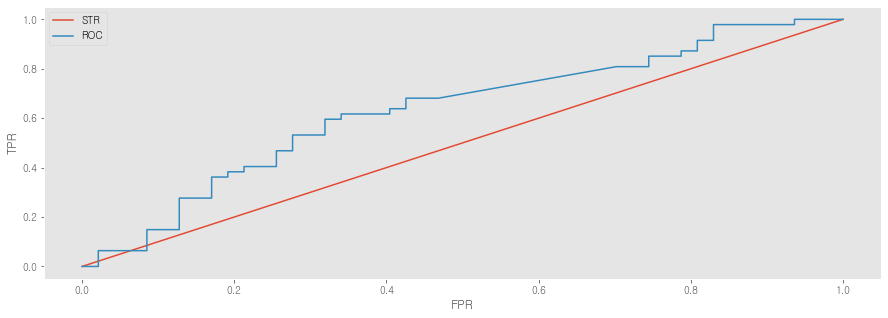

In [85]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [86]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [87]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [88]:
test_mlp.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,mlp_10,0.733364,0.680851,0.595745,0.765957,0.651163
3,mlp_15,0.718651,0.670213,0.553191,0.787234,0.626506
4,mlp_17,0.732911,0.702128,0.723404,0.680851,0.708333
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889
5,mlp_25,0.703486,0.691489,0.659574,0.723404,0.681319
6,mlp_30,0.633318,0.627660,0.680851,0.574468,0.646465
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465


## Ensemble

In [90]:
numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

In [91]:
#표준화
scaler = StandardScaler()

x_train_base_ensemble = x_train.copy()
x_test_base_ensemble = x_test.copy()


x_train_base_ensemble[numeric_cols] = scaler.fit_transform(x_train_base_ensemble[numeric_cols])
x_test_base_ensemble[numeric_cols] = scaler.transform(x_test_base_ensemble[numeric_cols])




In [92]:
x_train_rftree_ensemble20=x_train_base_ensemble[col_all[:20]]
x_test_rftree_ensemble20=x_test_base_ensemble[col_all[:20]]

x_train_rftree_ensemble10=x_train_base_ensemble[col_all[:10]]
x_test_rftree_ensemble10=x_test_base_ensemble[col_all[:10]]

x_train_rftree_ensemble15=x_train_base_ensemble[col_all[:15]]
x_test_rftree_ensemble15=x_test_base_ensemble[col_all[:15]]

x_train_rftree_ensemble17=x_train_base_ensemble[col_all[:17]]
x_test_rftree_ensemble17=x_test_base_ensemble[col_all[:17]]

x_train_rftree_ensemble25=x_train_base_ensemble[col_all[:25]]
x_test_rftree_ensemble25=x_test_base_ensemble[col_all[:25]]

x_train_rftree_ensemble30=x_train_base_ensemble[col_all[:30]]
x_test_rftree_ensemble30=x_test_base_ensemble[col_all[:30]]




### baseline

In [95]:
test_ensemble = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_ensemble

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [96]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [97]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.067,n_estimators=10,random_state=42 ) ),
    ('rfc', RandomForestClassifier(n_estimators=230, max_depth= 1,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(73,), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_base_ensemble, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.067,
                                                         n_estimators=10,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=1,
                                                     n_estimators=230,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(73,),
                                            learning_rate_init=0.1,
                                            max_iter

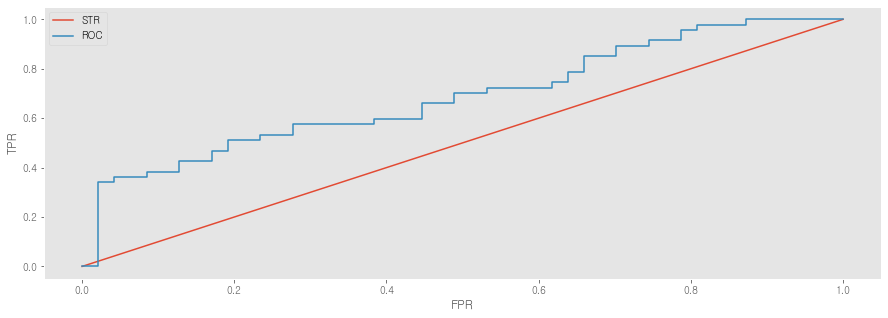

In [98]:
predicted=soft_vote.predict(x_test_base_ensemble)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_base_ensemble)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [99]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [100]:
test_ensemble= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_ensemble.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [101]:
test_ensemble

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,ensemble_base,0.686283,0.62766,0.574468,0.680851,0.606742


### reduced (20)

In [102]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=240, max_depth= 1,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(40,27), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble20, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=1,
                                                     n_estimators=240,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(40, 27),
                                            learning_rate_init=0.1,
                                            max_it

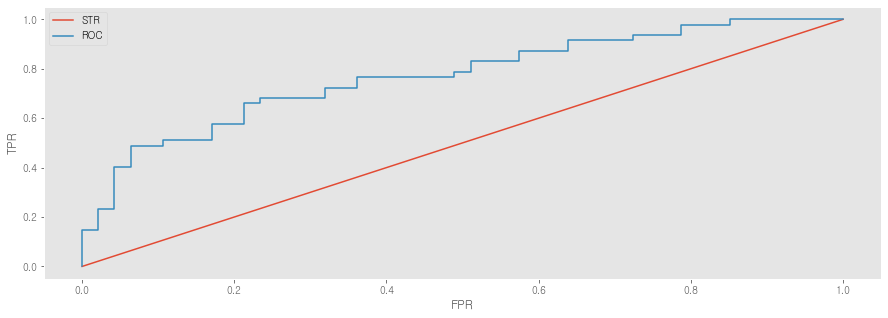

In [103]:
predicted=soft_vote.predict(x_test_rftree_ensemble20)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [104]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [105]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=200, max_depth= 3,random_state=42) ),
    ('svc', svm.SVC(C=10,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(29,26,90,27), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble10, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=10, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(29, 26, 90, 27),
                                            learning_rate_init=0.1,
                                           

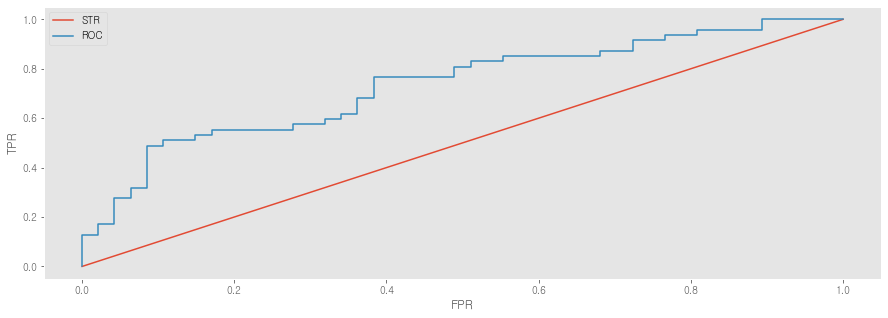

In [106]:
predicted=soft_vote.predict(x_test_rftree_ensemble10)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [107]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [108]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=200, max_depth= 3,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(37,62,50,97), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble15, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(37, 62, 50, 97),
                                            learning_rate_init=0.1,
                                          

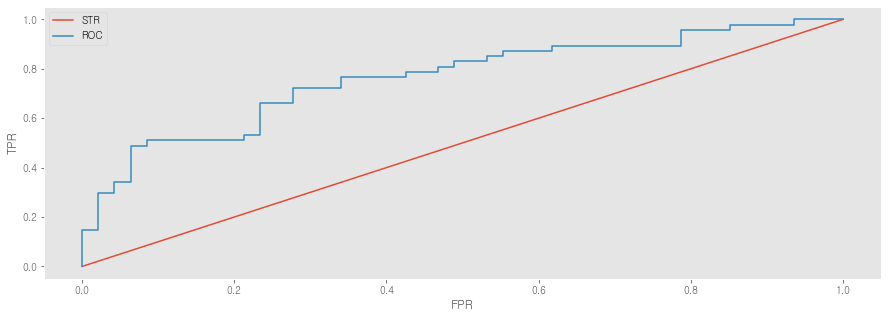

In [109]:
predicted=soft_vote.predict(x_test_rftree_ensemble15)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [110]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [111]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.07,n_estimators=11,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=240, max_depth= 2,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(61,33,100), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble17, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.07,
                                                         n_estimators=11,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=2,
                                                     n_estimators=240,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(61, 33, 100),
                                            learning_rate_init=0.1,
                                            m

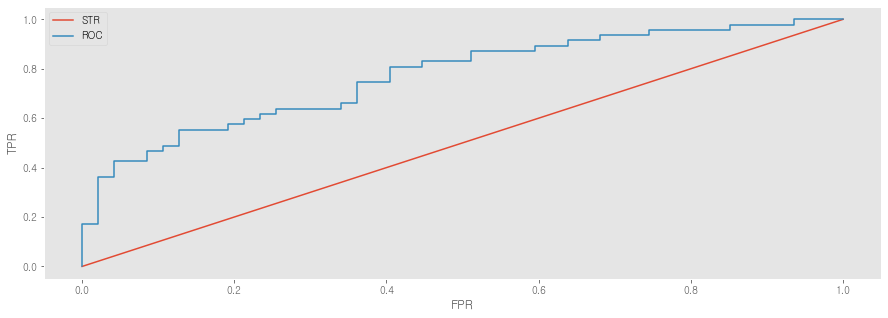

In [112]:
predicted=soft_vote.predict(x_test_rftree_ensemble17)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [113]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [114]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.07,n_estimators=11,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=180, max_depth= 3,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(57,33,42), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble25, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.07,
                                                         n_estimators=11,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=180,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(57, 33, 42),
                                            learning_rate_init=0.1,
                                            ma

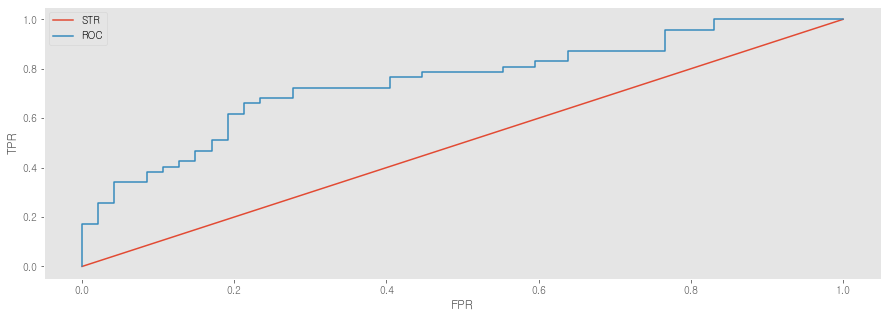

In [115]:
predicted=soft_vote.predict(x_test_rftree_ensemble25)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [116]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [117]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=240, max_depth= 1,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(96,74), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble30, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=1,
                                                     n_estimators=240,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(96, 74),
                                            learning_rate_init=0.1,
                                            max_it

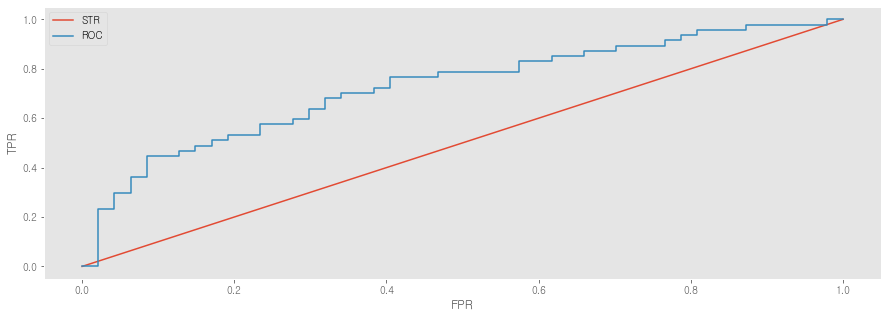

In [118]:
predicted=soft_vote.predict(x_test_rftree_ensemble30)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [119]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [120]:
test_ensemble= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_ensemble.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [121]:
test_ensemble.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,ensemble_10,0.732458,0.627660,0.574468,0.680851,0.606742
3,ensemble_15,0.763241,0.670213,0.574468,0.765957,0.635294
4,ensemble_17,0.770484,0.691489,0.595745,0.787234,0.658824
1,ensemble_20,0.769579,0.712766,0.680851,0.744681,0.703297
5,ensemble_25,0.747397,0.712766,0.659574,0.765957,0.696629
6,ensemble_30,0.726573,0.659574,0.574468,0.744681,0.627907
0,ensemble_base,0.686283,0.627660,0.574468,0.680851,0.606742


# 전체 비교

In [188]:
test_logistic.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,logistic_10,0.702580,0.521277,0.787234,0.255319,0.621849
3,logistic_15,0.699411,0.638298,0.808511,0.468085,0.690909
4,logistic_17,0.696243,0.595745,0.765957,0.425532,0.654545
1,logistic_20,0.701675,0.648936,0.765957,0.531915,0.685714
5,logistic_25,0.694885,0.648936,0.744681,0.553191,0.679612
6,logistic_30,0.668628,0.627660,0.723404,0.531915,0.660194
0,logistic_base,0.663649,0.659574,0.574468,0.744681,0.627907


In [189]:
test_svm.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,svm_10,0.753282,0.744681,0.617021,0.872340,0.707317
3,svm_15,0.747850,0.712766,0.553191,0.872340,0.658228
4,svm_17,0.751471,0.712766,0.553191,0.872340,0.658228
1,svm_20,0.745586,0.712766,0.553191,0.872340,0.658228
5,svm_25,0.775011,0.723404,0.553191,0.893617,0.666667
6,svm_30,0.765957,0.712766,0.617021,0.808511,0.682353
0,svm_base,0.759620,0.691489,0.574468,0.808511,0.650602


In [190]:
test_rf.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
1,rf_10,0.702128,0.702128,0.553191,0.851064,0.650000
2,rf_15,0.702128,0.702128,0.595745,0.808511,0.666667
3,rf_17,0.670213,0.670213,0.553191,0.787234,0.626506
0,rf_20,0.760072,0.691489,0.574468,0.808511,0.650602
4,rf_25,0.670213,0.670213,0.553191,0.787234,0.626506
5,rf_30,0.691489,0.691489,0.638298,0.744681,0.674157
6,rf_base,0.761800,0.691000,0.574000,0.809000,0.651000


In [94]:
test_mlp.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,mlp_10,0.733364,0.680851,0.595745,0.765957,0.651163
3,mlp_15,0.718651,0.670213,0.553191,0.787234,0.626506
4,mlp_17,0.732911,0.702128,0.723404,0.680851,0.708333
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889
5,mlp_25,0.703486,0.691489,0.659574,0.723404,0.681319
6,mlp_30,0.633318,0.627660,0.680851,0.574468,0.646465
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465


In [122]:
test_ensemble.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,ensemble_10,0.732458,0.627660,0.574468,0.680851,0.606742
3,ensemble_15,0.763241,0.670213,0.574468,0.765957,0.635294
4,ensemble_17,0.770484,0.691489,0.595745,0.787234,0.658824
1,ensemble_20,0.769579,0.712766,0.680851,0.744681,0.703297
5,ensemble_25,0.747397,0.712766,0.659574,0.765957,0.696629
6,ensemble_30,0.726573,0.659574,0.574468,0.744681,0.627907
0,ensemble_base,0.686283,0.627660,0.574468,0.680851,0.606742
